In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


In [2]:
datasets = joblib.load("all_pollutant_datasets.pkl")

POLLUTANTS = ["PM25", "PM10", "NO2", "SO2", "O3", "CO", "NOX"]


In [3]:
from pandas.tseries.offsets import DateOffset

def temporal_split(df):
    last_date = df["datetime"].max()
    test_start = last_date - DateOffset(months=6)
    val_start  = test_start - DateOffset(months=6)

    train = df[df["datetime"] < val_start]
    val   = df[(df["datetime"] >= val_start) & (df["datetime"] < test_start)]
    test  = df[df["datetime"] >= test_start]

    return train, val, test


In [4]:
BASE_FEATURES = [
    "lat", "lon",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "month", "is_weekend",
    "u", "v",
    "AT", "RH", "BP", "SolarRad", "Rain"
]

def get_feature_columns(df, target):
    lag_features = [
        c for c in df.columns
        if c.startswith(target + "_")
    ]
    return BASE_FEATURES + lag_features


In [5]:
def scale_features(train, val, test, features):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train[features])
    X_val   = scaler.transform(val[features])
    X_test  = scaler.transform(test[features])
    return X_train, X_val, X_test, scaler


In [6]:
def create_sequences(X, y, lookback=48):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i].reshape(-1))
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)


N-BEATS model

In [7]:
def nbeats_block(input_dim, units=256, layers_n=4):
    x = layers.Input(shape=(input_dim,))
    y = x
    for _ in range(layers_n):
        y = layers.Dense(units, activation="relu")(y)
    y = layers.Dense(1)(y)
    return models.Model(x, y)


Full N-BEATS model

In [8]:
def build_nbeats(input_dim, blocks=3):
    inp = layers.Input(shape=(input_dim,))
    residual = inp
    outputs = []

    for _ in range(blocks):
        block = nbeats_block(input_dim)
        forecast = block(residual)
        outputs.append(forecast)
        residual = layers.Subtract()([residual, forecast])

    out = layers.Add()(outputs)

    model = models.Model(inp, out)
    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"]
    )
    return model


Evaluation function

In [9]:
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2


Train N-BEATS for ALL pollutants

In [11]:
results = {}
predictions = {}

LOOKBACK = 48  # try 72 later if needed

for target in POLLUTANTS:
    print(f"\n===== Training N-BEATS for {target} =====")

    df = datasets[target]
    features = get_feature_columns(df, target)

    train, val, test = temporal_split(df)

    X_train, X_val, X_test, scaler = scale_features(train, val, test, features)
    y_train, y_val, y_test = train[target], val[target], test[target]

    X_train_seq, y_train_seq = create_sequences(X_train, y_train, LOOKBACK)
    X_val_seq, y_val_seq     = create_sequences(X_val, y_val, LOOKBACK)
    X_test_seq, y_test_seq   = create_sequences(X_test, y_test, LOOKBACK)

    model = build_nbeats(X_train_seq.shape[1])

    model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=50,
        batch_size=128,
        callbacks=[callbacks.EarlyStopping(patience=8, restore_best_weights=True)],
        verbose=1
    )

    preds = model.predict(X_test_seq).ravel()
    rmse, mae, r2 = evaluate(y_test_seq, preds)

    print(f"{target}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")

    results[target] = {"RMSE": rmse, "MAE": mae, "R2": r2}
    predictions[target] = (y_test_seq, preds)


===== Training N-BEATS for PM25 =====
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 382.6404 - mae: 8.8747 - val_loss: 66.1728 - val_mae: 5.7337
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 80.8722 - mae: 6.2140 - val_loss: 73.7959 - val_mae: 5.6707
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 65.2523 - mae: 5.5663 - val_loss: 58.7911 - val_mae: 5.3123
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 61.1854 - mae: 5.4388 - val_loss: 58.4485 - val_mae: 5.3415
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 53.6933 - mae: 5.0643 - val_loss: 60.8388 - val_mae: 5.3782
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 49.6114 - mae: 4.9066 - val_loss: 67.4248 - val_mae: 5.5339
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 53.7612 - mae: 5.0499 - val_loss: 61.8738 - val_mae: 5.4842
Epoch 8/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 49.9252 - mae: 4.8473 - val_loss: 59.2249 - val_mae:

In [12]:
print("\n===== N-BEATS Performance Summary =====")
for pol, m in results.items():
    print(f"{pol}: RMSE={m['RMSE']:.3f}, MAE={m['MAE']:.3f}, R²={m['R2']:.3f}")



===== N-BEATS Performance Summary =====
PM25: RMSE=6.502, MAE=4.921, R²=0.741
PM10: RMSE=11.628, MAE=8.698, R²=0.709
NO2: RMSE=4.596, MAE=3.297, R²=0.677
SO2: RMSE=0.565, MAE=0.445, R²=0.523
O3: RMSE=5.909, MAE=4.325, R²=0.680
CO: RMSE=219.988, MAE=165.581, R²=0.482
NOX: RMSE=9.994, MAE=6.838, R²=0.621


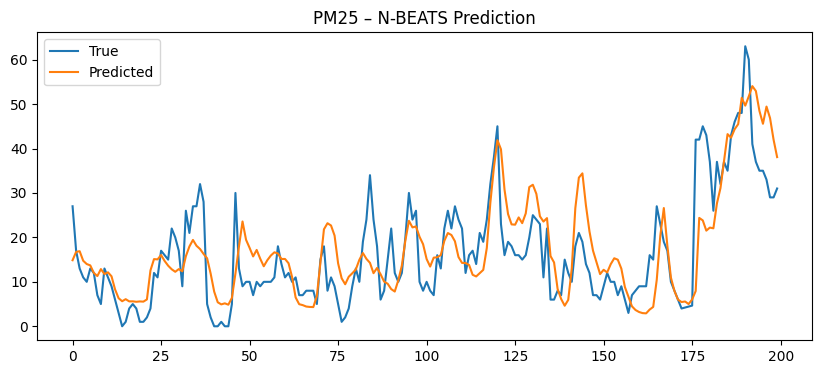

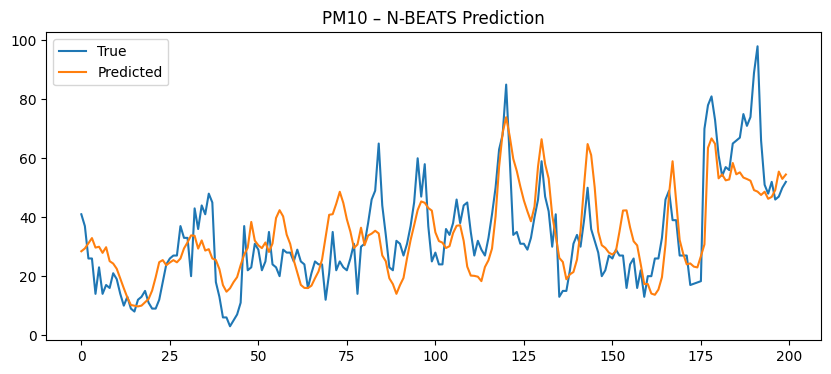

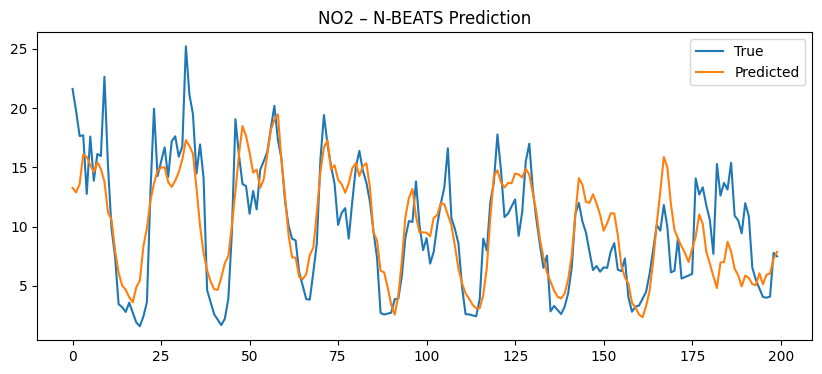

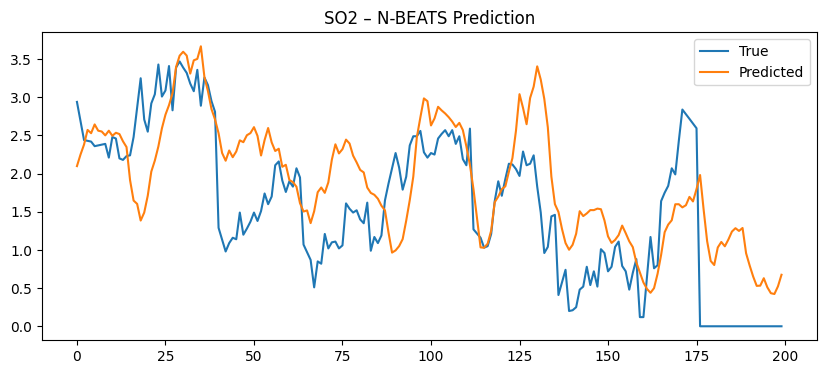

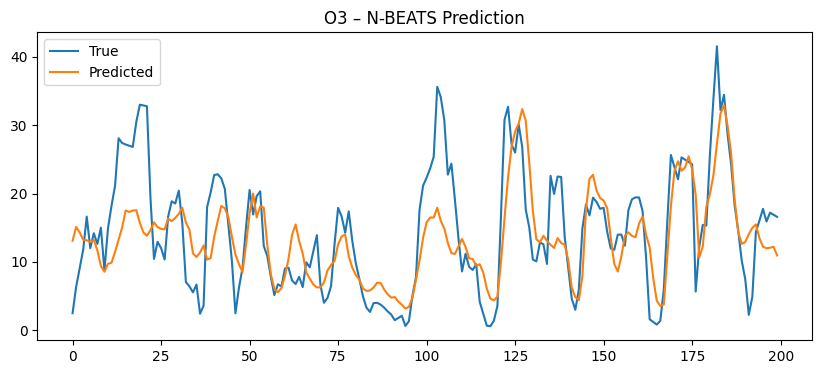

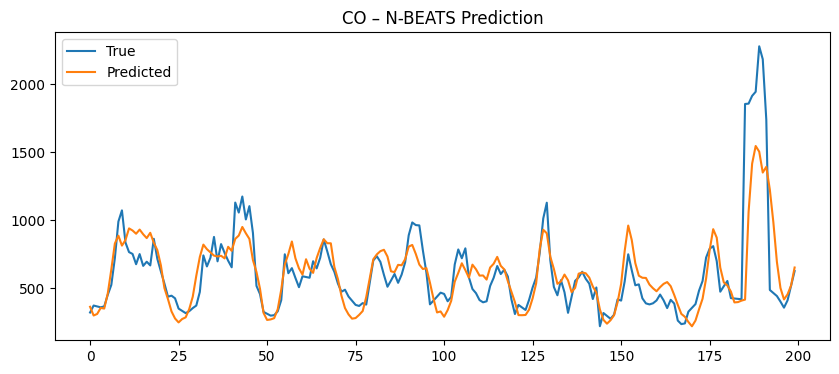

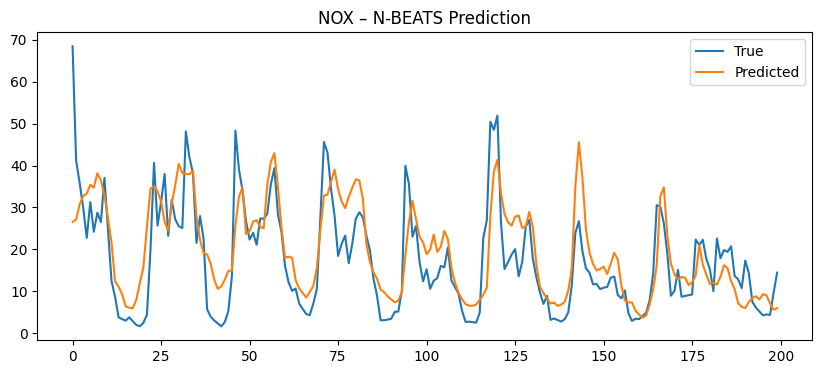

In [13]:
for pol, (y_true, y_pred) in predictions.items():
    plt.figure(figsize=(10,4))
    plt.plot(y_true[:200], label="True")
    plt.plot(y_pred[:200], label="Predicted")
    plt.title(f"{pol} – N-BEATS Prediction")
    plt.legend()
    plt.show()


In [14]:
# Save model (SAFE for TCN)
for target in POLLUTANTS:
    model.save(f"models/NBEATS_{target}.keras")